# setup

In [13]:
tables = ['volc.csv']
mydrive= 'E:/mydoc/git/trade/analyics/'
# """
tables = ['volcvn.csv',]#'volcvt.csv','volcva.csv','volcvg.csv']
from google.colab import drive
drive.mount('/content/drive')
mydrive='/content/drive/MyDrive/volrt/'
# Requirements:
%pip install git+https://github.com/jerronl/rtdl.git
#"""

appname='Xch_'
duration = 6
bad_value=-99999
vars_h, cat_names, ys,vars_c,= (
    ['date', 'diff', 'spot'],
    [],
    [[
        'close', 'hi', 'lo',
        'dtm','level','slope','curve',
         'dtm1','level1','slope1','curve1',
         'dtm2','level2','slope2','curve2',
         'dtm3','level3','slope3','curve3'],
         [ 'pmcat',],],
    ['Horizon','spot'],
)
import numpy as np

vars_h+=ys[0]
dep_vars=ys#[duration]
# vars_c=vars_c[duration]

ignore_load_zero=ignore_load_error=y_std=y_mean=X=y=loss_fn=my_model=jobsize=offset=start_epoch=optimizer = None

import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import rtdl.zero as zero
import matplotlib.pyplot as plt,os
%matplotlib inline
from typing import Optional
from torch import Tensor
import torch.nn as nn
import math
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from pickle import dump, load
import seaborn as sns
import random
from datetime import datetime

# !pip install cloud-tpu-client==0.10 torch==1.13.0 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/112/torch_xla-1.13-cp38-cp38-linux_x86_64.whl --force-reinstall
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

device = torch.device('cuda')
zero.improve_reproducibility(seed=1234567)
batch_size=int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*12
print(f'GPU mem:{int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)}G, batch_size:{batch_size}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://github.com/jerronl/rtdl.git to /tmp/pip-req-build-74t8px2u
  Running command git clone --filter=blob:none --quiet https://github.com/jerronl/rtdl.git /tmp/pip-req-build-74t8px2u
  Resolved https://github.com/jerronl/rtdl.git to commit f98ce61e5574c18e249a21e417e208f4832de808
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
GPU mem:16G, batch_size:192


# model

In [14]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000, position=None):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        if position is None:
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x
class PETrans(nn.Module):

    def __init__(self, duration, d_model,n_num_features,cat_cardinalities,d_out,x2):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        print("PETrans",duration, d_model,n_num_features,cat_cardinalities,d_out,x2)
        super().__init__()
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Linear(duration, d_model*2), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Dropout(0.1), #self.hparams.input_dropout),
            nn.GELU(), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Linear(d_model*2, d_model), # self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=d_model)
        self.unf=nn.Flatten(1,2)
        self.ftt= rtdl.FTTransformer.make_default(
            n_num_features=int(n_num_features/duration*d_model+x2),
            cat_cardinalities=cat_cardinalities,
            d_out=d_out,
            )

    def forward(self, x_num: Optional[Tensor], x_cat: Optional[Tensor], x2: Optional[Tensor]) -> Tensor:
        x = self.input_net(x_num)
        x = self.positional_encoding(x)
        x = self.unf(x)
        x = torch.cat((x, x2), 1)
        x = self.ftt(x, x_cat)
        return x

    def make_default_optimizer(self) -> torch.optim.AdamW:
        """Make the optimizer for the default FT-Transformer."""
        return self.ftt.make_default_optimizer()

def apply_model(model, x_num, x_cat=None, x2=None):
    return model(x_num, x_cat, x2)

@torch.no_grad()
def evaluate(mload=None,part='val'):
    model=mload or my_model
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], batch_size):
        prediction.append(apply_model(model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2]))
    prediction = torch.cat(prediction)
    target = y[part]
    prediction2 = prediction[:,-y_cat:].argmax(1)
    mask = ~torch.isnan(target[:,:-1])
    score = (F.mse_loss(prediction[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
          ((target[:,-1]!=prediction2).sum()/len(prediction))

    return score,target, prediction,prediction2

@torch.no_grad()
def validate(mload=None):
  score,target, prediction,prediction2 = evaluate(mload,'test')
  print(jobname,f'{score:.4f}')
  target, prediction, prediction2 = target.squeeze(1).cpu().numpy(), prediction.squeeze(1).cpu().numpy(), prediction2.cpu().numpy()
  sns.jointplot(x=target[:,-1] , y=prediction2,kind="kde",fill=True,rug=True)
  prediction[:,-y_cat]=prediction2
  sns.set(style="whitegrid")
  dep_var=dep_vars[0]+dep_vars[1]
  figs=min(len(dep_var),4)
  _, axes = plt.subplots(math.ceil(len(dep_var)/figs), figs, figsize=(16,16))
  for i,name in enumerate(dep_var):
      axs=axes.flat[i] if figs>1 else axes
      sns.regplot(ax=axs, x=target[:,i] , y=prediction[:,i],
                scatter_kws = {'color': 'purple', 'alpha': 0.3},
                line_kws = {'color': '#CCCC00', 'alpha': 0.3}
                )
      axs.set_title(name)
      mask=~np.isnan(target[:,i])
      if not dep_var[i][:3] in ['dtm','pmc']:
        axs.set_xlim(left=max(np.min(target[:,i][mask]), -2.5),
                      right=min(np.max(target[:,i][mask]),2.5))
      else:
        axs.set_xlim(left=np.min(target[:,i][mask]),
                            right=np.max(target[:,i][mask]))
  plt.show()

def cross_entropy_mse_loss_with_nans(input, target):
    mask = ~torch.isnan(target[:,:-1])
    return (F.mse_loss(input[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
      (F.cross_entropy (input[:,-y_cat:],target[:,-1].type(torch.LongTensor).to(device)))

def model_path():
  return mydrive+jobname+'checkpoint.pt'

def save_model(improved=False):
  path=mydrive+jobname+'checkpoint.pt'
  torch.save(
      {
          'model':  my_model.state_dict() if improved or not os.path.exists(path) else #else #
                    torch.load(path)['model'],
          'optimizer': optimizer.state_dict(),
          'epoch': epoch,
          'random_state': zero.random.get_state (),
          'jobsize': jobsize,
          'offset': offset,
      },
      path
  )

def load_model():
  global jobsize,offset,start_epoch,my_model,optimizer
  start_epoch=1
  jobsize=int(len(X_all)*0.1)
  if resume:
    path=mydrive+jobname+'checkpoint.pt'
    if os.path.exists(path):
      try:
        checkpoint = torch.load(path,map_location=device)
        my_model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        try:
          zero.random.set_state(checkpoint['random_state'])
        except (AssertionError,) as err:
          if ignore_load_zero:
            print("zero error:",err)
          else:
            raise err
        print(f'loaded {jobname} epoch {start_epoch}')
        if 'jobsize' in checkpoint and checkpoint['jobsize']==jobsize:
          offset=checkpoint['offset']
        else:
          raise ValueError('size diffs now',jobsize,
                checkpoint['jobsize'] if 'jobsize' in checkpoint else 0)
        return True
      except Exception as error:
        if ignore_load_error:
          print("failed to load: ", error)
        else:
          raise error
  random.seed(datetime.now().timestamp())
  offset=random.randint(-jobsize*3,-jobsize*2)
  return False

def job_name():
  return appname+''.join(filter(lambda x: x not in "[' ", str(dep_vars[0])))[:8]

def setup_data():
  global jobname,X,y, my_model,optimizer,train_loader,progress,y_mean,y_std,loss_fn,y_cat
  dep_var=dep_vars[0]+dep_vars[1]
  jobname=job_name()
  y_all=torch.tensor(dfo.loc[:,dep_var].to_numpy(), device=device)

  y_cat = int(max(y_all[:,-1]))
  y_all[:,-1]-=1
  d_out = y_cat+y_all.shape[1]-1
  print(jobname,y_all.shape)

  X,y = {},{}
  my_model=PETrans(
      duration=duration,
      d_model=16,
      n_num_features=len(cont_names),
      cat_cardinalities=[len(arr) for arr in enc.categories_],
      d_out=d_out,
      x2=len(vars_c)
      ).to(device)

  optimizer = (
      my_model.make_default_optimizer()
  )
  load_model()
  print('offset ',offset)
  X['train'], X['test'], y['train'], y['test']  = (
      np.concatenate((X_all[:offset],X_all[offset+jobsize:])),
      X_all[offset:offset+jobsize],
      torch.cat((y_all[:offset],y_all[offset+jobsize:])),
      y_all[offset:offset+jobsize],
  )
  X['train'], X['val'],  y['train'], y['val']  = sklearn.model_selection.train_test_split(
      X['train'], y['train'], train_size=0.9
  )
  X2, X['test'], y2, y['test']  = sklearn.model_selection.train_test_split(
      X['test'], y['test'], train_size=0.05
  )
  X['val'], y['val']=np.concatenate((X['val'], X['test'])),torch.cat(( y['val'], y['test']))
  X['train'], y['train']=np.concatenate((X['train'], X2)),torch.cat(( y['train'], y2))

  X = {
      k: (torch.tensor(v[:,:len(cat_names)], device=device).to(torch.int64),
          torch.tensor(v[:,-len(cont_names):].reshape((v.shape[0],int(len(cont_names)/duration),duration)), device=device),
          torch.tensor(v[:,len(cat_names):-len(cont_names)], device=device),)
      for k, v in X.items()
  }
  # y = {k: torch.tensor(v, device=device) for k, v in y.items()}
  mask=torch.masked.masked_tensor(y['train'],y['train']!=bad_value)
  y_mean,y_std=mask.mean(dim=0).to_tensor(0),mask.std(dim=0).to_tensor(0)
  cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
  for k,v in y.items():
    v[v==bad_value]=float('nan')
    v[:,cols_to_norm]=((v-y_mean) / y_std)[:,cols_to_norm]
    y[k]=v


  y = {k: v.float() for k, v in y.items()}

  train_loader = zero.data.IndexLoader(len(X['train'][0]), batch_size, device=device)
  progress = zero.ProgressTracker(patience=100)
  loss_fn = cross_entropy_mse_loss_with_nans

def boxplot(vars,bad_value=None):
  i=j=min(5,len(vars))
  for _,var in enumerate(vars):
      if isinstance(var,list):
        y=pd.Series()
        for name in var:
          if name in dfo.columns:
            y=y.append(dfo[name],ignore_index = True)
      else:
        y=dfo[var] if var in dfo.columns else []
        name=var
      if len(y)>0:
        if i>=j:
          figure, axes = plt.subplots(1,j,figsize=(16,8))
          i=0
        axs=axes.flat[i]
        i+=1
        if bad_value is not None and y.min()<=bad_value:
          mask=y!=bad_value
          name=f'{name}_{mask.sum()/len(mask):.0%}'
          y=y[mask]
        sns.boxplot(ax=axs, y=y, showmeans=True,
                          meanprops={"marker": "+",
                        "markeredgecolor": "black",
                        "markersize": "10"})
        axs.set_title(name)
  plt.show()


def set_state(state: Dict[str, Any]) -> None:
    """Set global random states in `random`, `numpy` and `torch`.

    Args:
        state: global RNG states. Must be produced by `get_state`. The size of the list
            :code:`state['torch.cuda']` must be equal to the number of available cuda
            devices.

    See also:
        `get_state`

    Raises:
        AssertionError: if :code:`torch.cuda.device_count() != len(state['torch.cuda'])`
    """
    random.setstate(state['random'])
    np.random.set_state(state['numpy.random'])
    torch.random.set_rng_state(state['torch.random'].cpu())
    assert torch.cuda.device_count() == len(state['torch.cuda'])
    torch.cuda.set_rng_state_all([v.cpu() for v in state['torch.cuda']])  # type: ignore

zero.random.set_state=set_state


In [ ]:
import gc

my_model.cpu()
del my_model
gc.collect()
torch.cuda.empty_cache()

# Training

(261601, 156) (261601, 134) 19
0.4607417402838674 0.000000   -1.795600
0.005000   -1.049730
0.052973   -0.582740
0.100946   -0.400276
0.148918   -0.291400
0.196891   -0.224840
0.244864   -0.165746
0.292837   -0.118370
0.340810   -0.080540
0.388783   -0.044070
0.436755   -0.012380
0.486183    0.012250
0.537064    0.047390
0.587946    0.087790
0.638828    0.132624
0.689710    0.180220
0.740591    0.232700
0.791473    0.290150
0.842355    0.364850
0.893237    0.478597
0.944118    0.662623
0.995000    1.444910
1.000000    2.273400
Name: close, dtype: float64


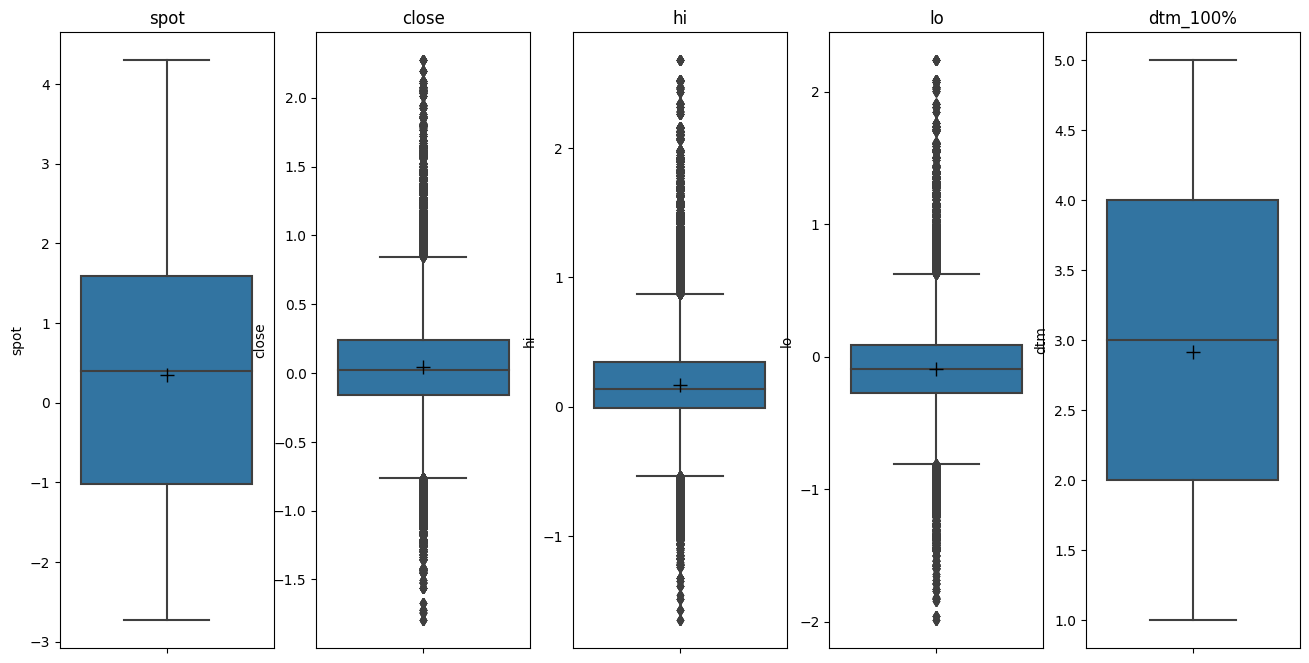

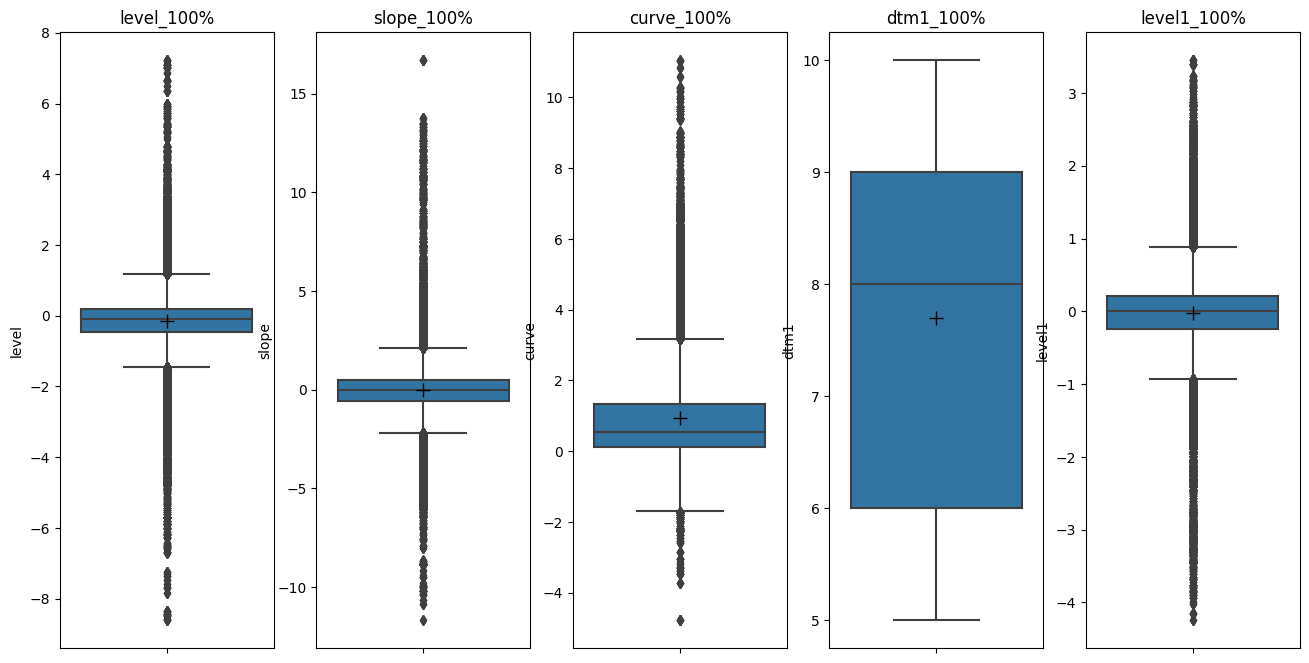

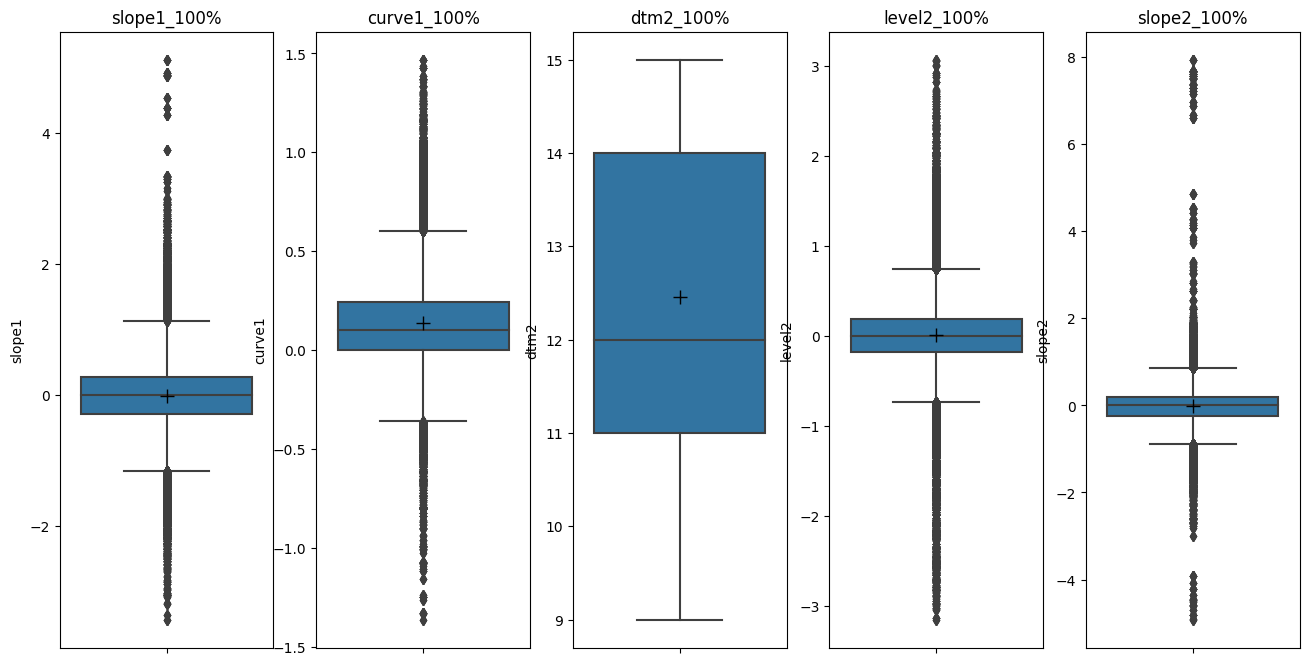

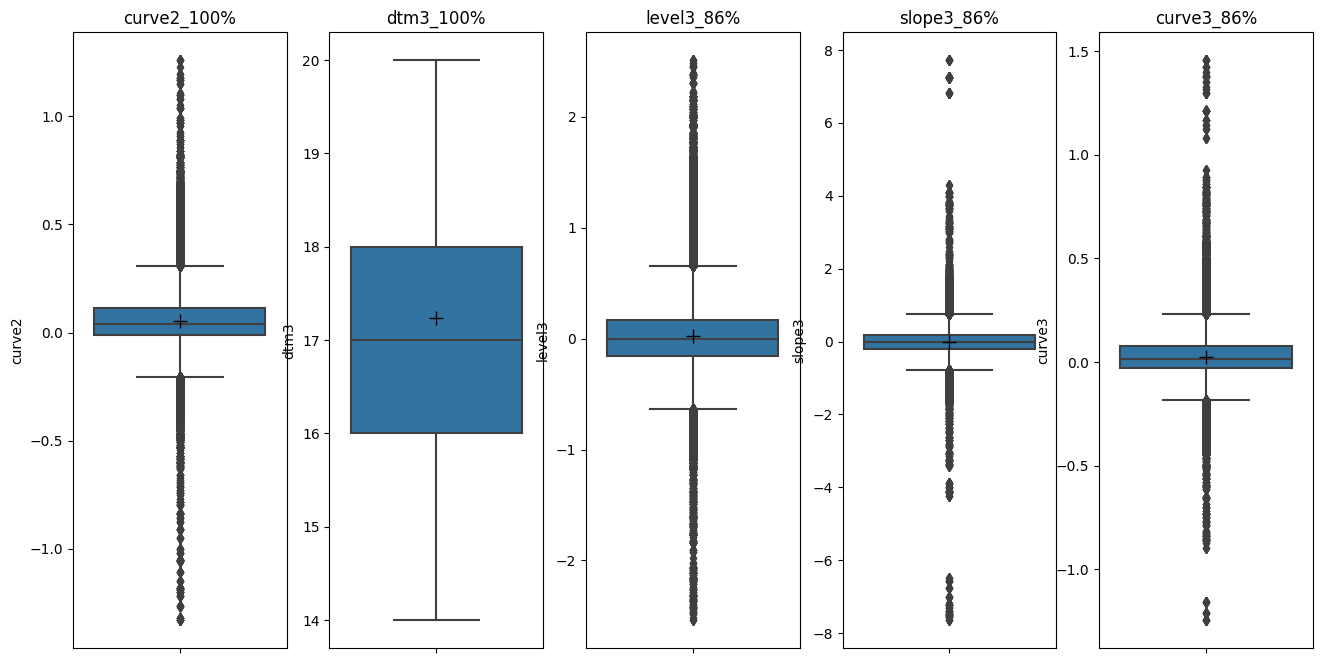

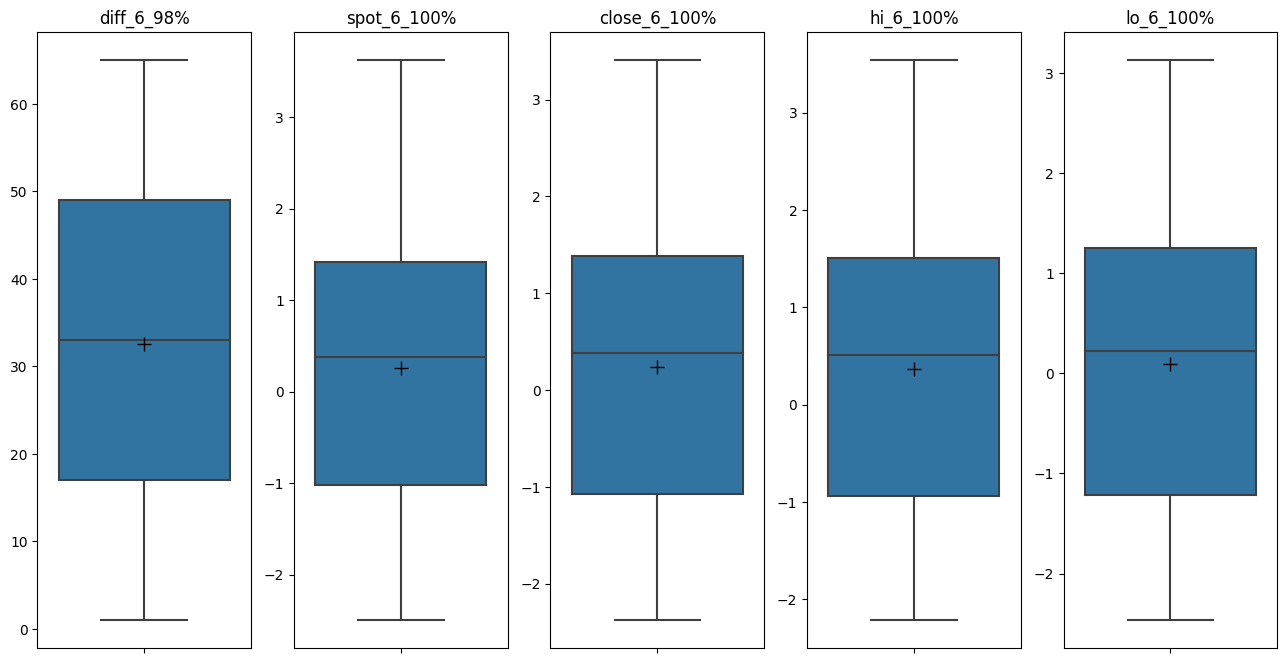

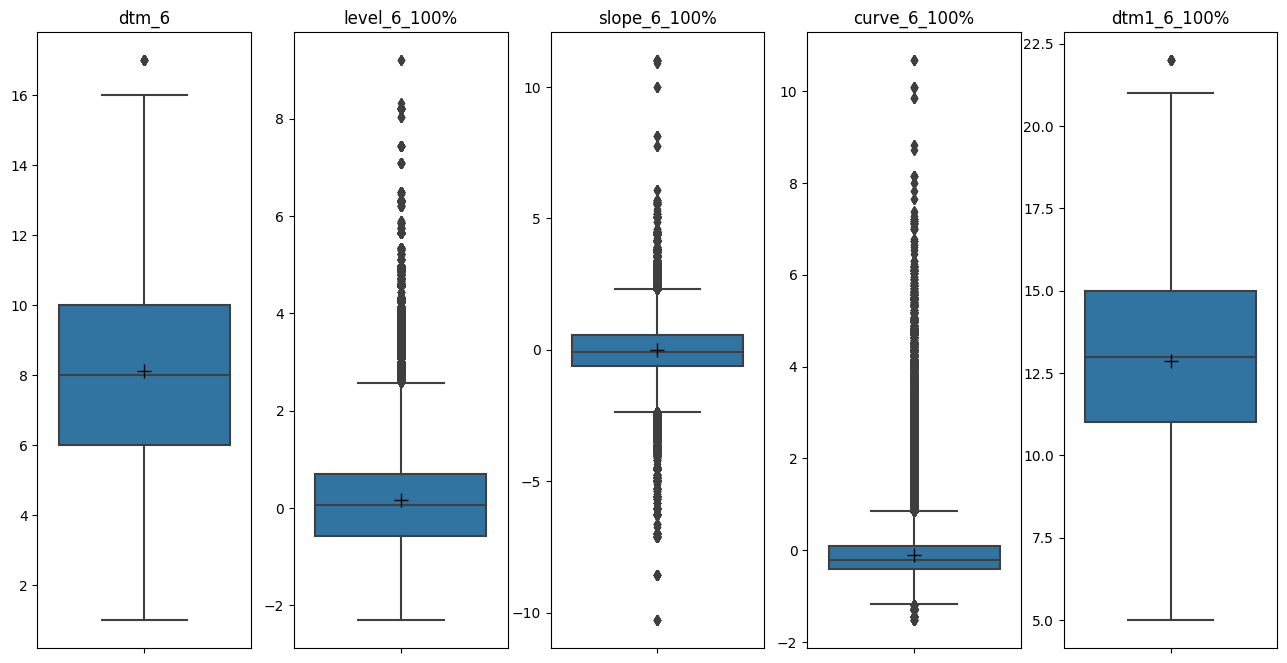

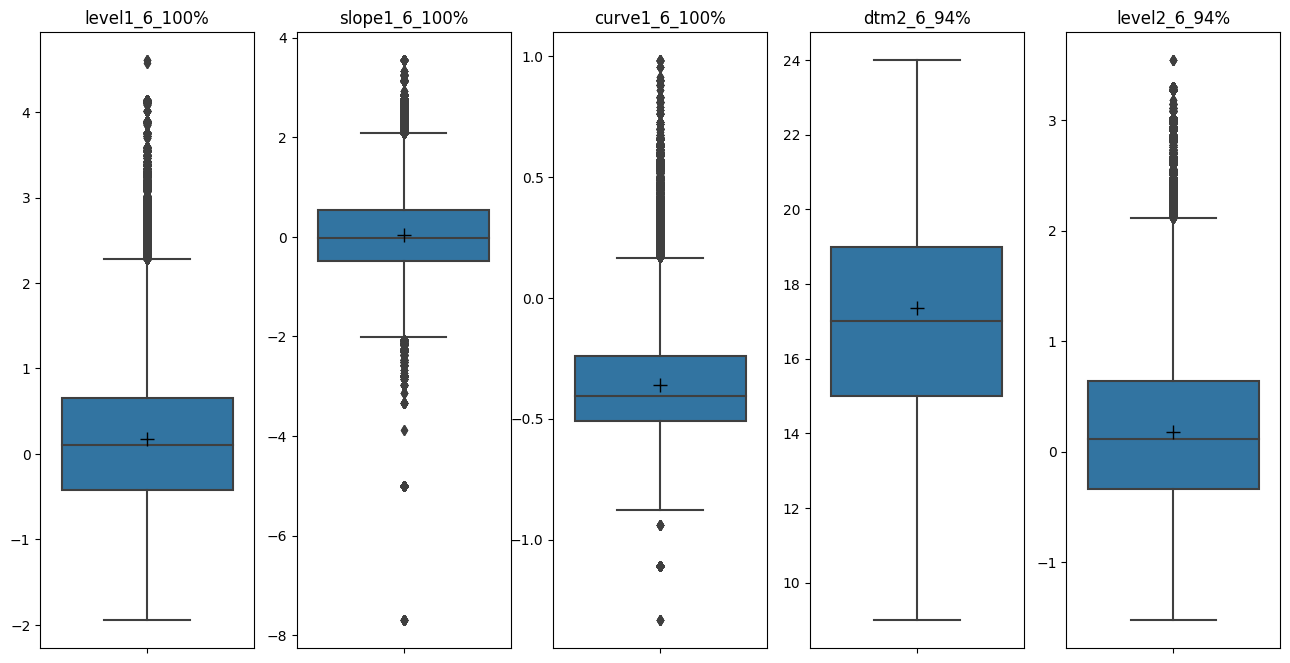

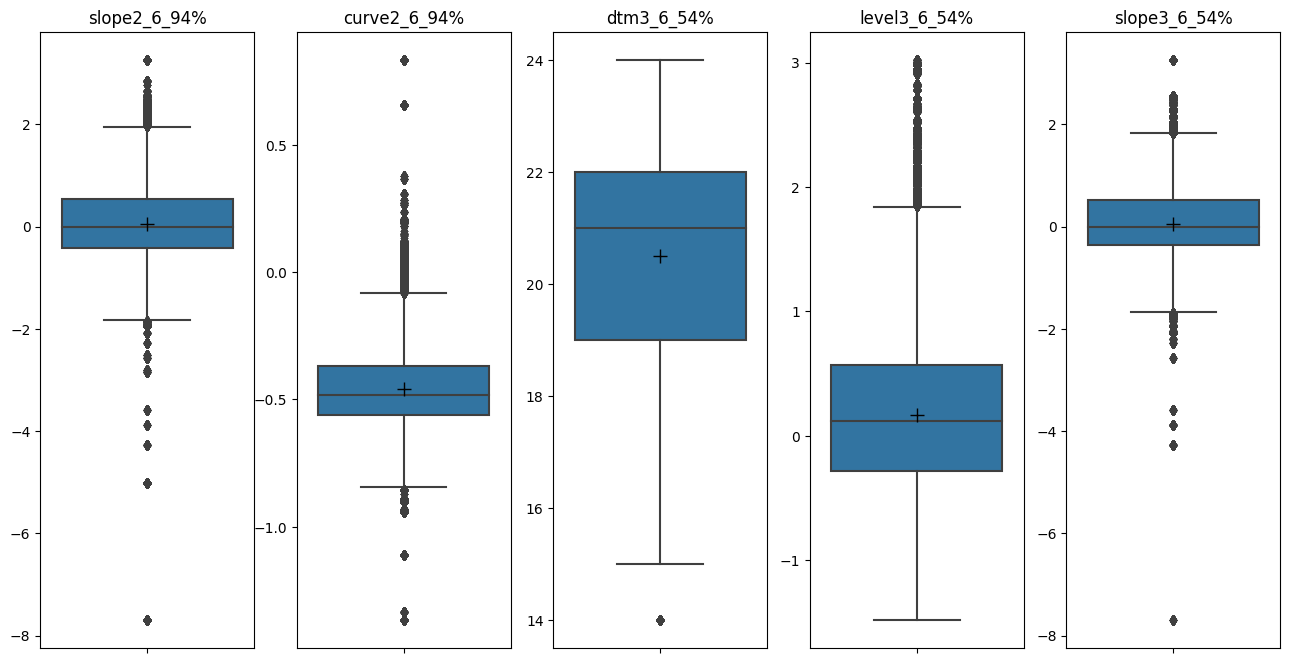

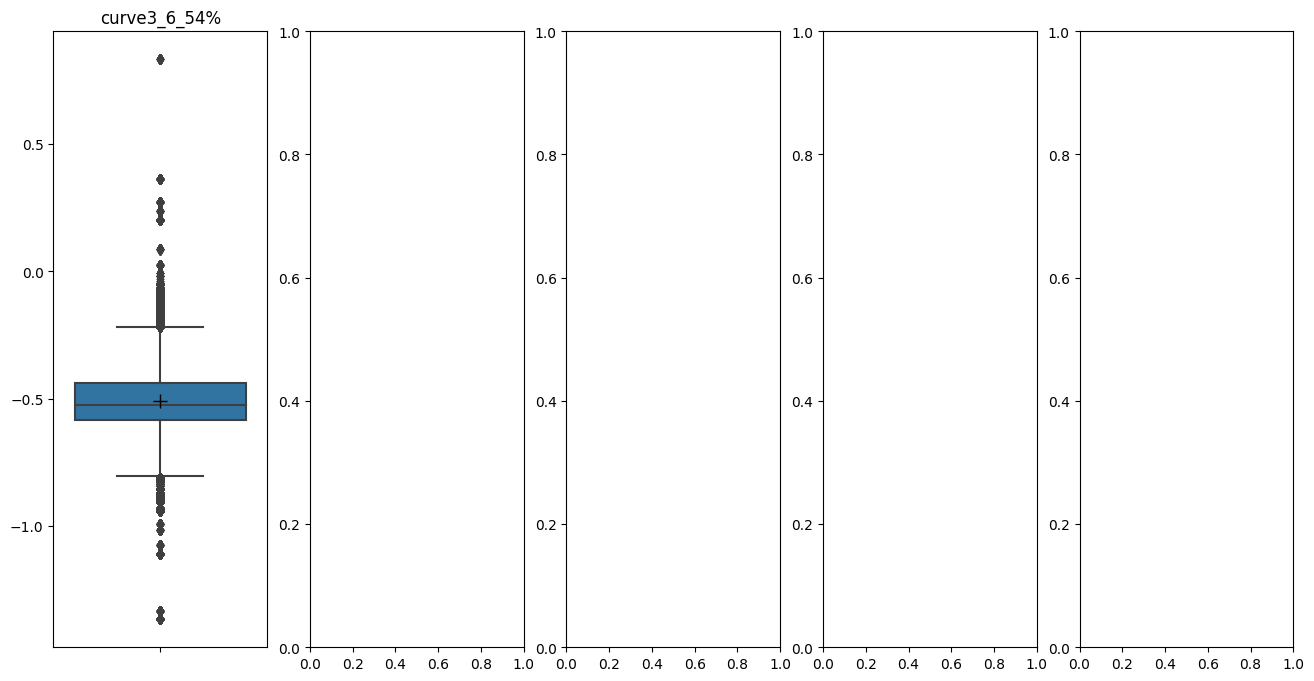

In [15]:
next_dep = 0
# next_dep=1
# next_dep=2
# next_dep=3
resume = True  # False#
# tables = ['volcva.csv']
tables = ['volcvn.csv','volcvt.csv','volcva.csv','volcvg.csv']
dfo = pd.DataFrame()
for table in tables:
    df = pd.read_csv(mydrive + table)
    dfo = pd.concat([dfo, df])

cont_names=[]
for var in vars_h:
    for i in range(duration):
        mvar = f'{var}_{i+1}'
        if not mvar in dfo.columns:
            dfo[mvar] = 0
        cont_names.append(mvar)

dfo.sort_values(by=['date'])
enc = OrdinalEncoder()
dfo[cat_names] = enc.fit_transform(dfo[cat_names])
X_all = dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')

print(dfo.shape, X_all.shape,len(dep_vars[0]))
zero_perc=(1-len(dfo[dfo['close']>0])/len(dfo)+len(dfo[dfo['close']<0])/len(dfo))/2
print(zero_perc,dfo['close'].quantile([0]+[i*(zero_perc-0.005)/9.5+0.005 for i in range(10)]+[0.995-(0.995-zero_perc)/10.5*(21-i) for i in range(11,22)]+[1]))
boxplot(vars_h[1:],bad_value)
boxplot([[f'{var}_{i+1}' for i in range(duration)] for var in vars_h[1:]],0)


In [ ]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(dfo[dfo['spot']>15].iloc[0])

date                1.000000
Horizon             0.689260
spot               16.698330
dtm                -0.009540
level               6.000000
slope              -0.088530
curve               0.192480
dtm1                0.109350
level1             11.000000
slope1              0.007510
curve1              0.151630
dtm2               -0.005490
level2             16.000000
slope2              0.025560
curve2              0.093490
dtm3               -0.005640
level3          45112.663460
slope3          45113.663910
curve3          45114.665170
date_1          45117.656940
date_2          45118.401760
date_3          45119.663630
date_4             16.000000
date_5             15.000000
date_6             14.000000
diff_1             13.000000
diff_2             12.000000
diff_3             11.000000
diff_4              0.118490
diff_5              0.011730
diff_6              0.069280
hi                 13.000000
lo                  1.719230
close               1.767600
pmcat         

# run


In [ ]:
# next_dep=0
# resume=False#s
# resume=True#False#
# ignore_load_error=True
# ignore_load_zero=True

n_epochs = 900
n_trials = 50
start_epoch = 1
sub_epochs=10

for dep_sec in range(next_dep, len(dep_vars)):
    n_no_improve = 0
    setup_data()
    print(X['train'][0].shape, X['train'][1].shape, y['train'].shape)
    validate()
    resume=True
    # report_frequency = len(X['train']) // batch_size // 5
    for epoc in range(start_epoch, n_epochs , sub_epochs):
      for epoch in range(epoc,epoc+sub_epochs):
        for iteration, batch_idx in enumerate(train_loader):
            my_model.train()
            optimizer.zero_grad()
            x_batch = (X['train'][0][batch_idx] if len(cat_names)>0 else None,
                       X['train'][1][batch_idx],
                       X['train'][2][batch_idx])
            y_batch = y['train'][batch_idx]
            loss = loss_fn(
                apply_model(my_model,
                            x_cat=x_batch[0] if len(cat_names)>0 else None,
                            x_num=x_batch[1], x2=x_batch[2]).squeeze(1),
                y_batch)
            loss.backward()
            optimizer.step()
            # if iteration % report_frequency == 0:
            #     print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

        val_score = evaluate()[0]
        # test_score = evaluate(my_model,'test')[0]
        print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f}', end=" ")
        progress.update(-val_score)
        if progress.success:
            print(' <<< BEST VALIDATION EPOCH')
            save_model(True)
            n_no_improve = 0
        else:
            save_model(False)
            n_no_improve += 1
            print(f' no improve {n_no_improve}')
        if progress.fail or val_score < .01 or n_no_improve > n_trials:
            break
      if progress.fail or val_score < .01 or n_no_improve > n_trials:
        break
      if n_no_improve<sub_epochs:
        load_model()
      else:
        print("noload",n_no_improve,sub_epochs)
    with open(mydrive + jobname, 'wb') as filehandler:
        dump((my_model, y_std, y_mean, enc), filehandler)
    validate()

## manual

In [ ]:

    # setup_data(0)
    prediction = []
    i=0
    with torch.no_grad():
      my_model.eval()
      for batch in zero.iter_batches(X['test'], batch_size):
      # batch=next(zero.iter_batches(X['test'], batch_size))
      # if True:
        prediction.append(apply_model(my_model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2]))
    prediction = torch.cat(prediction)
    target = y['test']#[i:i+batch_size]
    if task_type == 'binclass':
      prediction = np.round(scipy.special.expit(prediction))
      score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
      prediction = prediction.argmax(1)
      score = (target.reshape(-1)!=prediction).sum()/len(prediction)
    else:
      assert task_type == 'regression'
      score =mse_loss_with_nans(prediction, target, ) ** 0.5

    score,target, prediction


In [ ]:
for i in range(len(target)):
  if target[i][0]==1 and prediction[i][0]>2:
    print(i,target[i],prediction[i])

15382 tensor([ 1.0000e+00,  6.0205e-01, -4.2817e-01,  1.0109e+00,  5.0000e+00,
         4.9149e-01, -2.0451e-01, -4.4114e-01,  1.0000e+01,  1.5667e-01,
         2.5629e-01, -7.5276e-01,  1.5000e+01,  1.1539e-01, -9.2124e-01,
        -6.9835e-03], device='cuda:0') tensor([ 2.6289,  0.2052,  0.0468, -0.5407,  7.4679,  0.1687,  0.1701, -0.5982,
        12.2171,  0.0882,  0.0640, -0.2971, 16.9601,  0.0372,  0.1261, -0.1165],
       device='cuda:0')
18262 tensor([ 1.0000e+00,  3.3884e-02,  2.2153e-03, -5.6351e-01,  5.0000e+00,
         2.6321e-02, -6.4948e-01, -7.7102e-02,  1.0000e+01, -5.2886e-02,
        -4.5381e-01, -2.7395e-01,  1.5000e+01, -7.9756e-02, -5.3078e-01,
        -5.1002e-02], device='cuda:0') tensor([ 2.6289,  0.2052,  0.0468, -0.5407,  7.4679,  0.1687,  0.1701, -0.5982,
        12.2170,  0.0882,  0.0641, -0.2971, 16.9601,  0.0371,  0.1262, -0.1164],
       device='cuda:0')


In [ ]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(dfo[(dfo['dtm']==1)&(dfo['diff_1']==19)&(dfo['dtm_1']==10)&(dfo['Horizon']<4)].iloc[10])

date            #2022-10-06 10:29:58#
Horizon                             2
spot                         -0.94172
dtm                                 1
level                        -0.13269
slope                         1.34783
curve                         0.38551
dtm1                                6
level1                        0.06577
slope1                        0.27589
curve1                        0.10309
dtm2                               11
level2                        0.10553
slope2                         0.2063
curve2                        0.06762
dtm3                               16
level3                        0.09173
slope3                        0.19436
curve3                       -0.00611
date_1                    44827.66397
date_2                    44830.66464
date_3                    44833.57739
date_4                    44834.44378
date_5                     44837.3959
date_6                    44838.55333
diff_1                             19
diff_2      

Xch_close,hi 8.3318


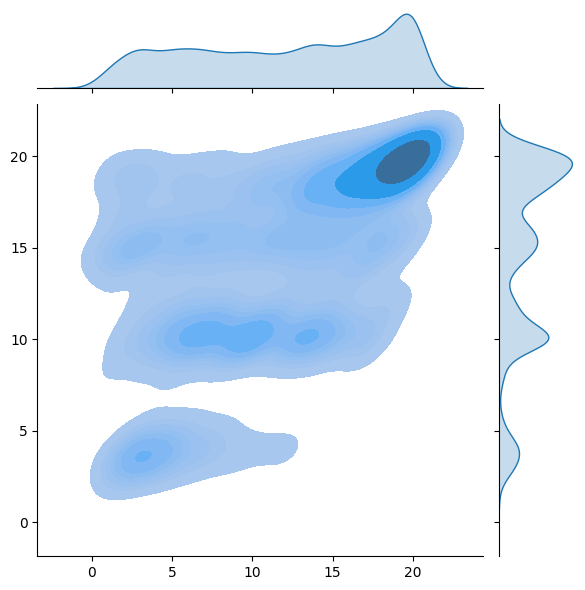

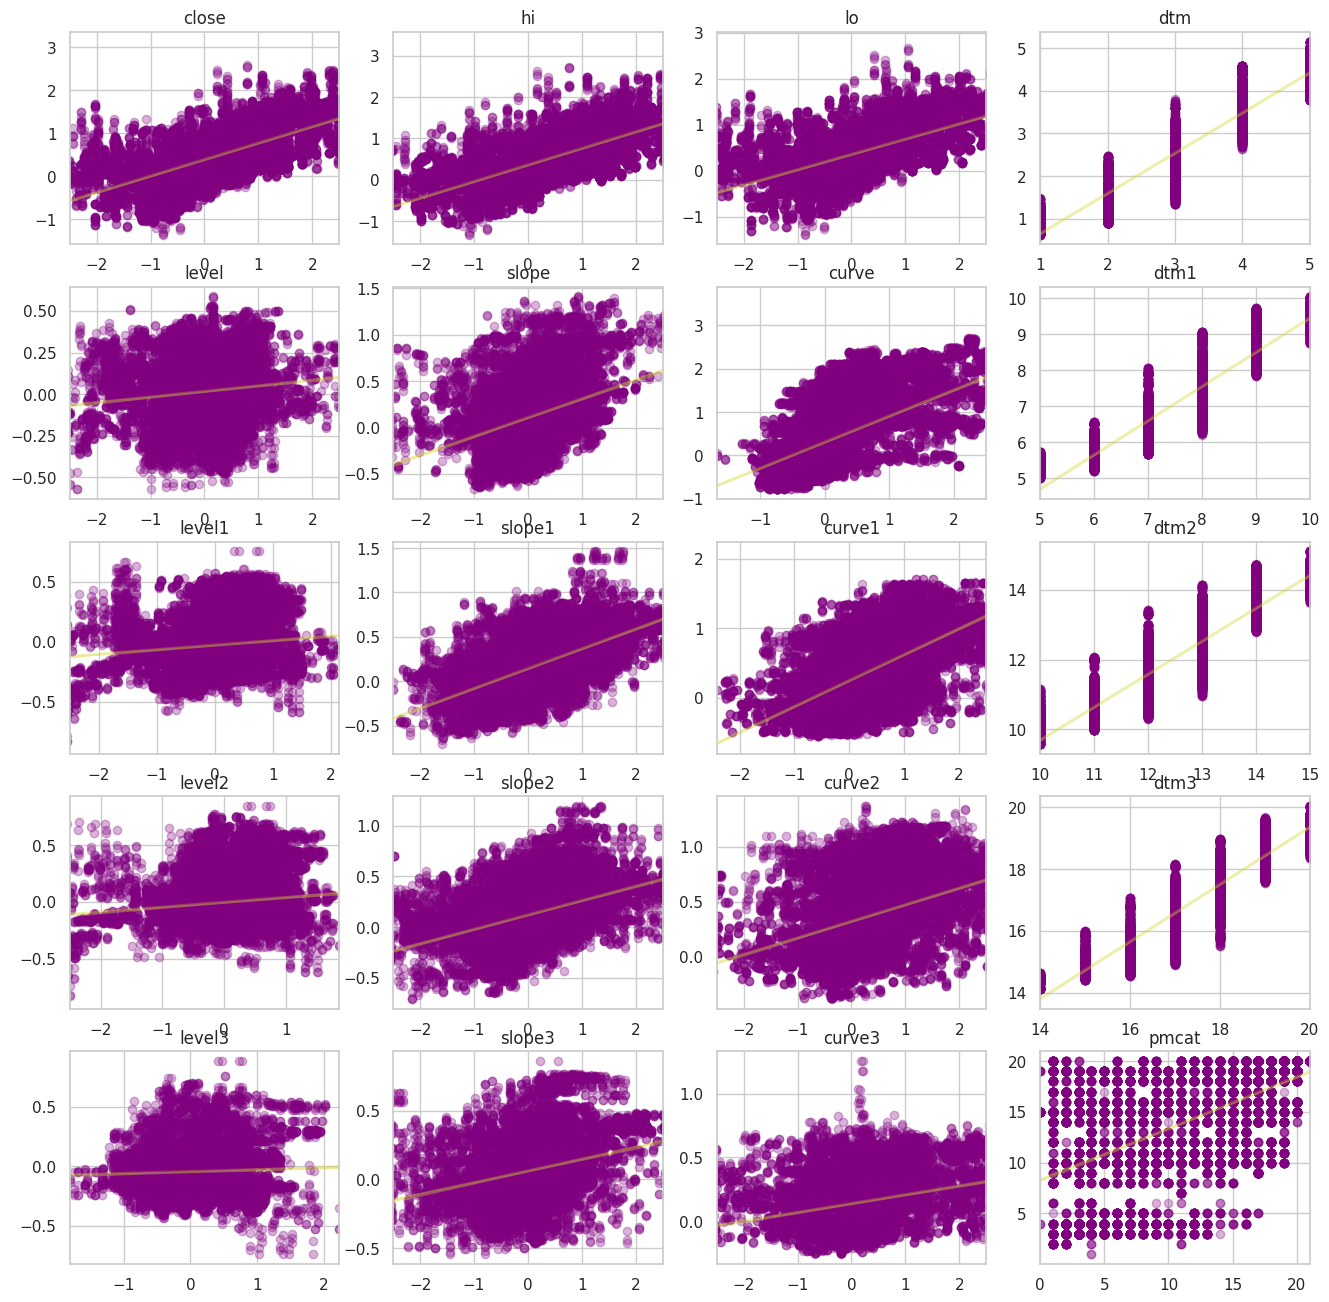

In [5]:
validate()

## export

In [4]:
X_all = dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')
resume=True
ignore_load_zero=True
ignore_load_error=True

if len(dep_vars)>0:
  setup_data()
  with open(mydrive + jobname, 'wb') as filehandler:
      dump((my_model, y_std, y_mean, enc), filehandler)


Xch_close,hi torch.Size([261601, 20])
PETrans 6 16 132 [] 41 2
loaded Xch_close,hi epoch 79
offset  -73060


# valid

In [6]:
last_run = "2023-09-15"
next_run = "2023-08-30"

models, cont_names = [], []
jobname = job_name()
with open(mydrive + jobname, 'rb') as filehandler:
    models.append(load(filehandler))

dfo = pd.DataFrame()
for table in tables:
    df = pd.read_csv(mydrive + table)
    df = df.query(f'date>"#{next_run}"')
    dfo = pd.concat([dfo, df])

for var in vars_h:
    for i in range(duration):
        mvar = f'{var}_{i+1}'
        if not mvar in dfo.columns:
            dfo[mvar] = 0
        cont_names.append(mvar)

enc=models[0][3]
dfo[cat_names] = enc.fit_transform(dfo[cat_names])

def val_period():
    global jobname, X, y, my_model, y_mean, y_std
    for period in [[last_run, '9999'], [next_run, last_run]]:
        print(period)
        df = dfo.query(f'date>"#{period[0]}" and date<"#{period[1]}"')
        dep_var=dep_vars[0]+dep_vars[1]
        X, y = ({'test':
                 (  # dfo.loc[:,cat_names+vars_c+cont_names].to_numpy().astype('float32')},{}
                     torch.tensor(df.loc[:, cat_names].to_numpy(), device=device).to(torch.int64),
                     torch.tensor(df.loc[:, cont_names].to_numpy().astype('float32').reshape((df.shape[0], int(len(cont_names) / duration), duration)), device=device),
                     torch.tensor(df.loc[:, vars_c].to_numpy().astype('float32'), device=device),
                 )
                 }, {'test': torch.tensor(df.loc[:,dep_var].to_numpy(), device=device).float()})
        print('duration: ', duration,df.shape, X['test'][0].shape, X['test'][1].shape, X['test'][2].shape)
        y['test'][:,-1]-=1

        for learner in models:
            jobname = job_name()
            my_model, y_std, y_mean, enc = learner
            y['test'][y['test']==bad_value]=float('nan')
            cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
            y['test'][:,cols_to_norm]=((y['test']-y_mean) / y_std)[:,cols_to_norm].float()
            validate()

['2023-09-15', '9999']
duration:  6 (3870, 156) torch.Size([3870, 0]) torch.Size([3870, 22, 6]) torch.Size([3870, 2])
Xch_close,hi 6.7753


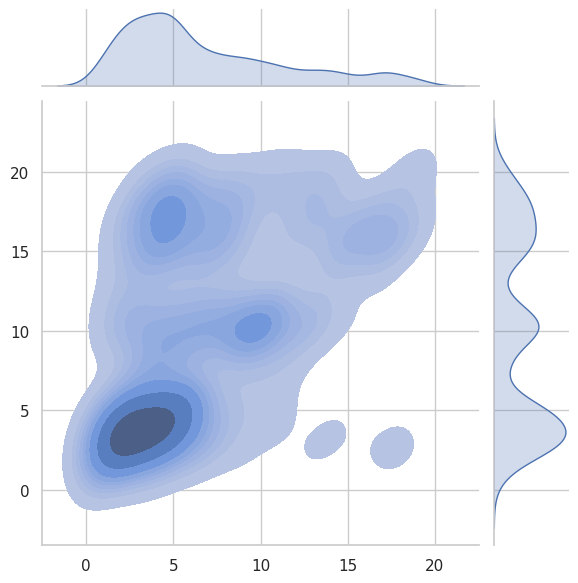

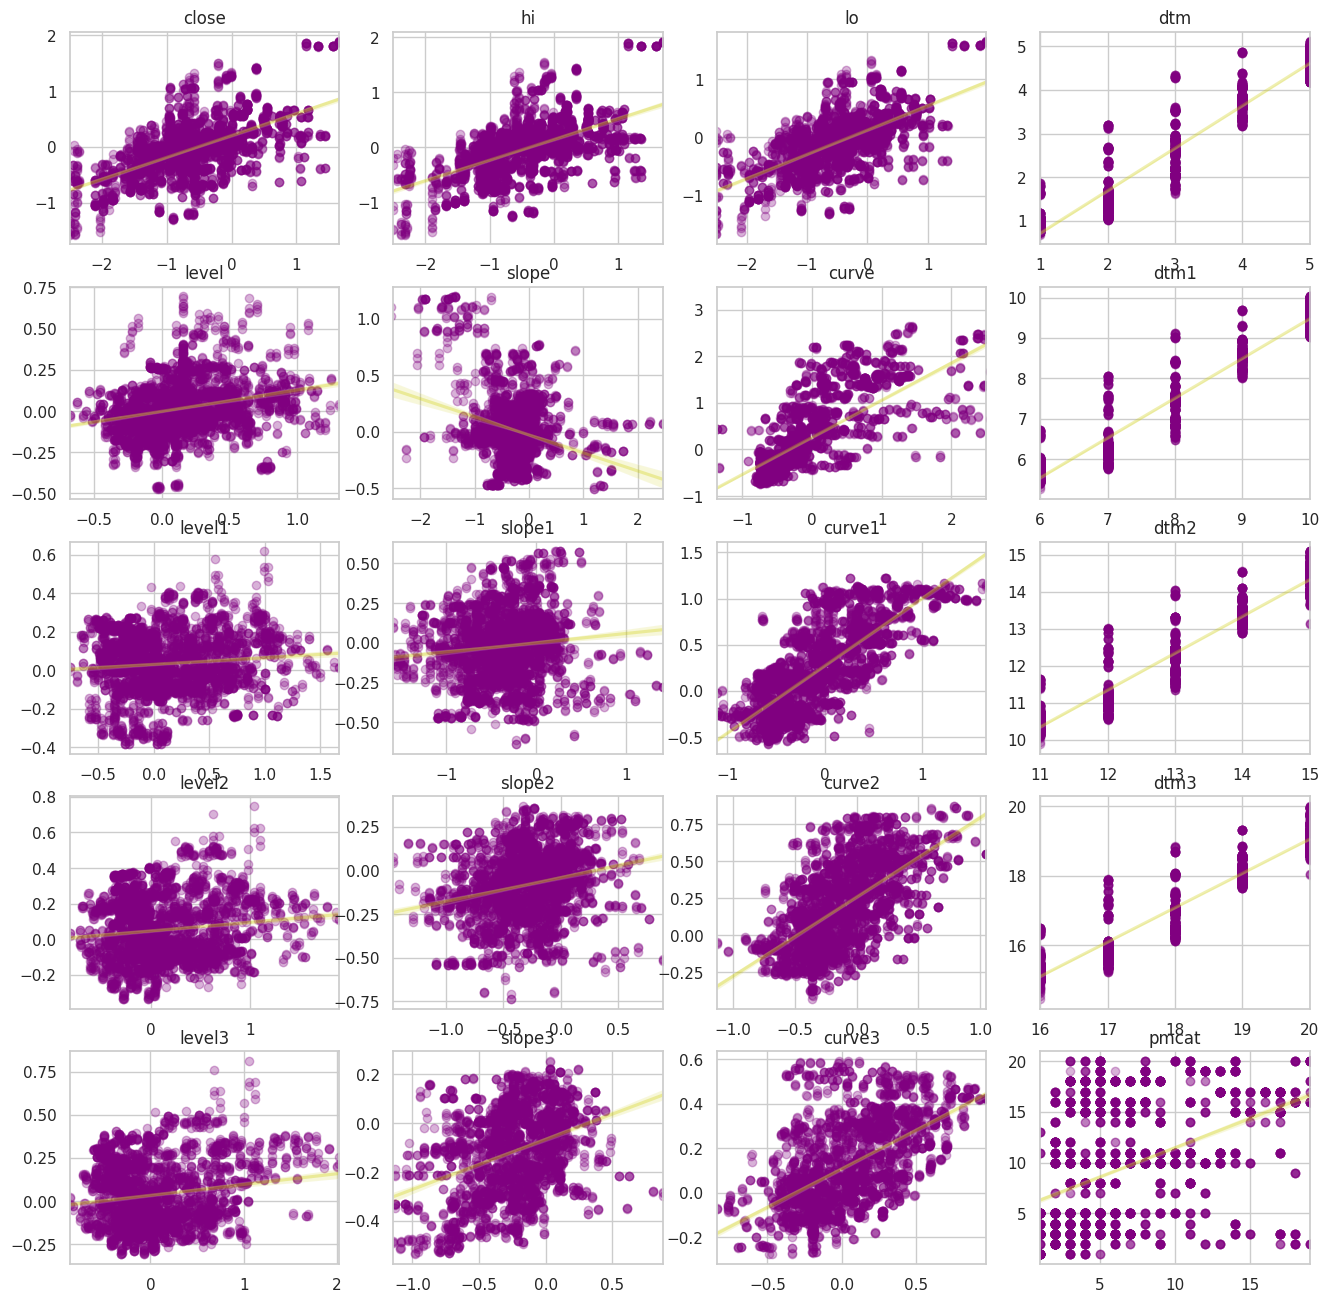

['2023-08-30', '2023-09-15']
duration:  6 (7416, 156) torch.Size([7416, 0]) torch.Size([7416, 22, 6]) torch.Size([7416, 2])
Xch_close,hi 6.9439


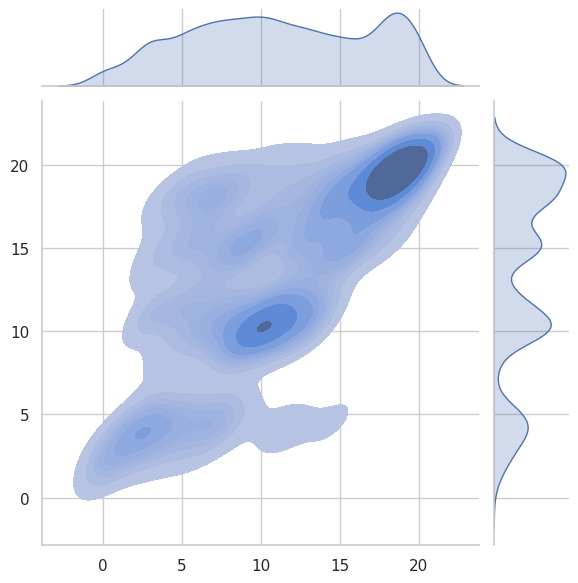

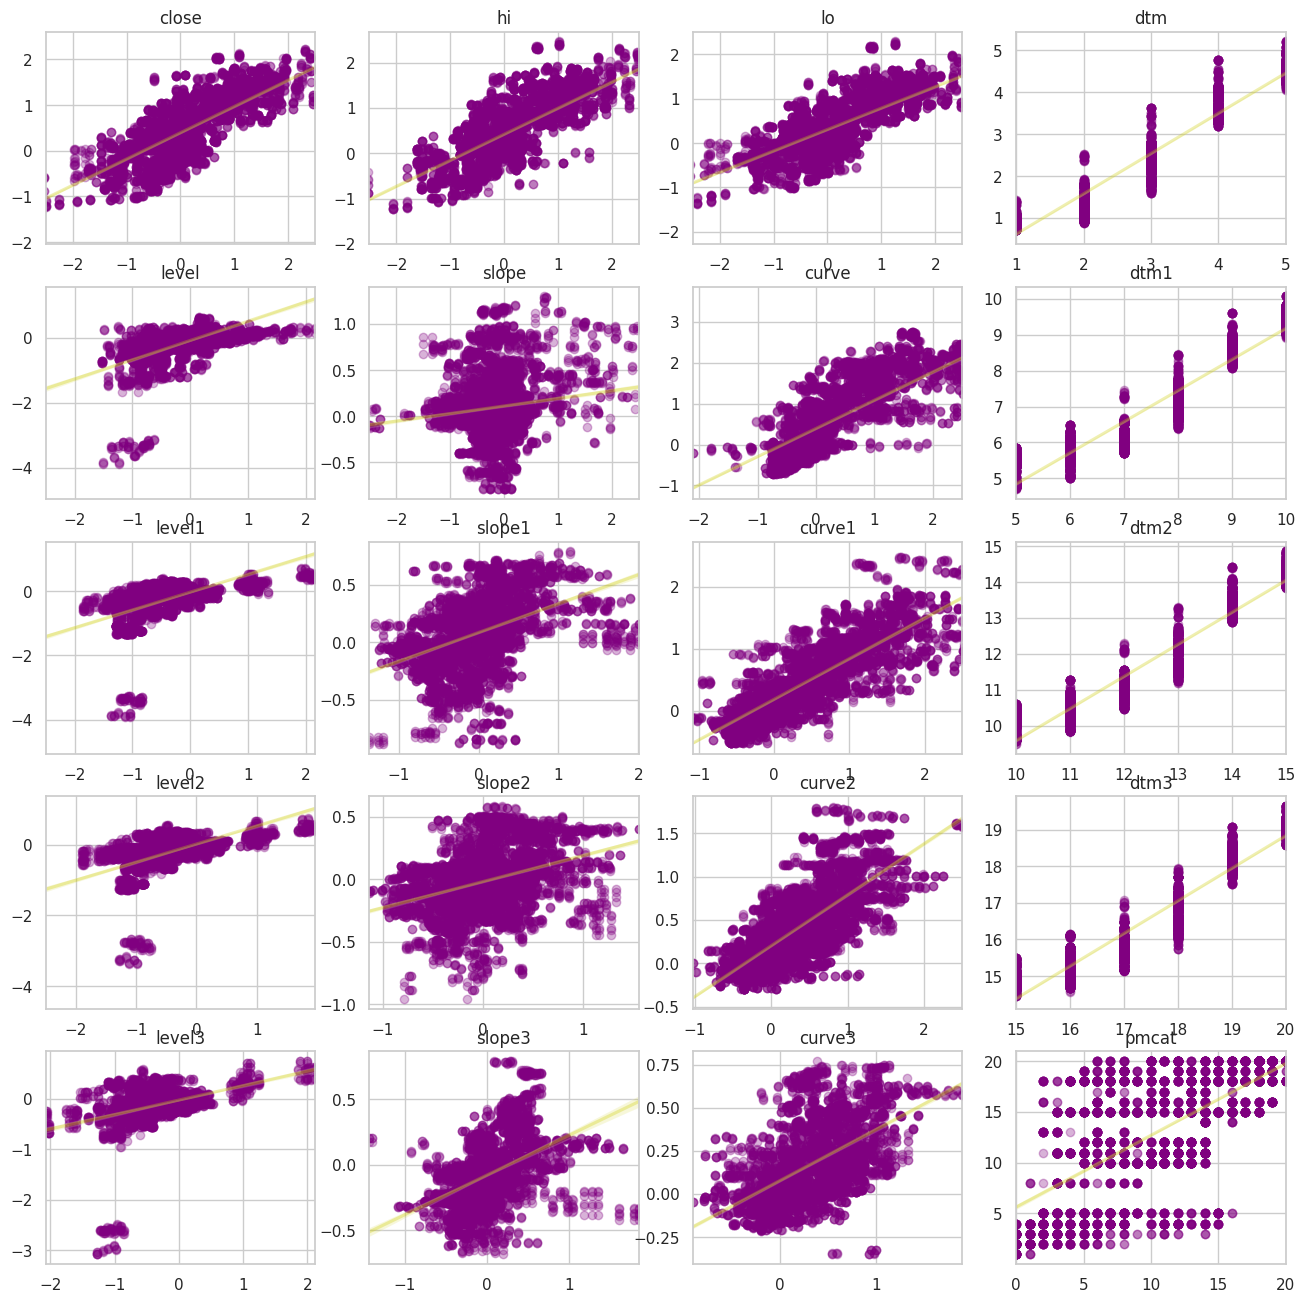

In [7]:
val_period()

## after

In [ ]:
val_period()

# all

In [ ]:
tables = ['volc.csv']
mydrive= 'E:/mydoc/git/trade/analyics/'
# """
tables = ['volcvn.csv','volcvt.csv','volcva.csv','volcvg.csv']
from google.colab import drive
drive.mount('/content/drive')
mydrive='/content/drive/MyDrive/volrt/'
# Requirements:
%pip install git+https://github.com/jerronl/rtdl.git
#"""

appname='Xch_'
duration = 6
bad_value=-99999
vars_h, cat_names, ys,vars_c,= (
    ['date', 'diff', 'spot'],
    [],
    [[
        'close', 'hi', 'lo',
        'dtm','level','slope','curve',
         'dtm1','level1','slope1','curve1',
         'dtm2','level2','slope2','curve2',
         'dtm3','level3','slope3','curve3'],
         [ 'pmcat',],],
    ['Horizon','spot'],
)
import numpy as np

vars_h+=ys[0]
dep_vars=ys#[duration]
# vars_c=vars_c[duration]

ignore_load_zero=ignore_load_error=y_std=y_mean=X=y=loss_fn=my_model=jobsize=offset=start_epoch=optimizer = None

import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import rtdl.zero as zero
import matplotlib.pyplot as plt,os
%matplotlib inline
from typing import Optional
from torch import Tensor
import torch.nn as nn
import math
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from pickle import dump, load
import seaborn as sns
import random
from datetime import datetime

# !pip install cloud-tpu-client==0.10 torch==1.13.0 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/112/torch_xla-1.13-cp38-cp38-linux_x86_64.whl --force-reinstall
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

device = torch.device('cuda')
zero.improve_reproducibility(seed=1234567)
batch_size=int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*12
print(f'GPU mem:{int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)}G, batch_size:{batch_size}')

################################################## model ############################
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000, position=None):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        if position is None:
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x
class PETrans(nn.Module):

    def __init__(self, duration, d_model,n_num_features,cat_cardinalities,d_out,x2):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        print("PETrans",duration, d_model,n_num_features,cat_cardinalities,d_out,x2)
        super().__init__()
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Linear(duration, d_model*2), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Dropout(0.1), #self.hparams.input_dropout),
            nn.GELU(), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Linear(d_model*2, d_model), # self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=d_model)
        self.unf=nn.Flatten(1,2)
        self.ftt= rtdl.FTTransformer.make_default(
            n_num_features=int(n_num_features/duration*d_model+x2),
            cat_cardinalities=cat_cardinalities,
            d_out=d_out,
            )

    def forward(self, x_num: Optional[Tensor], x_cat: Optional[Tensor], x2: Optional[Tensor]) -> Tensor:
        x = self.input_net(x_num)
        x = self.positional_encoding(x)
        x = self.unf(x)
        x = torch.cat((x, x2), 1)
        x = self.ftt(x, x_cat)
        return x

    def make_default_optimizer(self) -> torch.optim.AdamW:
        """Make the optimizer for the default FT-Transformer."""
        return self.ftt.make_default_optimizer()

def apply_model(model, x_num, x_cat=None, x2=None):
    return model(x_num, x_cat, x2)

@torch.no_grad()
def evaluate(mload=None,part='val'):
    model=mload or my_model
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], batch_size):
        prediction.append(apply_model(model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2]))
    prediction = torch.cat(prediction)
    target = y[part]
    prediction2 = prediction[:,-y_cat:].argmax(1)
    mask = ~torch.isnan(target[:,:-1])
    score = (F.mse_loss(prediction[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
          ((target[:,-1]!=prediction2).sum()/len(prediction))

    return score,target, prediction,prediction2

@torch.no_grad()
def validate(mload=None):
  score,target, prediction,prediction2 = evaluate(mload,'test')
  print(jobname,f'{score:.4f}')
  target, prediction, prediction2 = target.squeeze(1).cpu().numpy(), prediction.squeeze(1).cpu().numpy(), prediction2.cpu().numpy()
  sns.jointplot(x=target[:,-1] , y=prediction2,kind="kde",fill=True,rug=True)
  prediction[:,-y_cat]=prediction2
  sns.set(style="whitegrid")
  dep_var=dep_vars[0]+dep_vars[1]
  figs=min(len(dep_var),4)
  _, axes = plt.subplots(math.ceil(len(dep_var)/figs), figs, figsize=(16,16))
  for i,name in enumerate(dep_var):
      axs=axes.flat[i] if figs>1 else axes
      sns.regplot(ax=axs, x=target[:,i] , y=prediction[:,i],
                scatter_kws = {'color': 'purple', 'alpha': 0.3},
                line_kws = {'color': '#CCCC00', 'alpha': 0.3}
                )
      axs.set_title(name)
      mask=~np.isnan(target[:,i])
      if not dep_var[i][:3] in ['dtm','pmc']:
        axs.set_xlim(left=max(np.min(target[:,i][mask]), -2.5),
                      right=min(np.max(target[:,i][mask]),2.5))
      else:
        axs.set_xlim(left=np.min(target[:,i][mask]),
                            right=np.max(target[:,i][mask]))
  plt.show()

def cross_entropy_mse_loss_with_nans(input, target):
    mask = ~torch.isnan(target[:,:-1])
    return (F.mse_loss(input[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
      (F.cross_entropy (input[:,-y_cat:],target[:,-1].type(torch.LongTensor).to(device)))

def model_path():
  return mydrive+jobname+'checkpoint.pt'

def save_model(improved=False):
  path=mydrive+jobname+'checkpoint.pt'
  torch.save(
      {
          'model':  my_model.state_dict() if improved or not os.path.exists(path) else #else #
                    torch.load(path)['model'],
          'optimizer': optimizer.state_dict(),
          'epoch': epoch,
          'random_state': zero.random.get_state (),
          'jobsize': jobsize,
          'offset': offset,
      },
      path
  )

def load_model():
  global jobsize,offset,start_epoch,my_model,optimizer
  start_epoch=1
  jobsize=int(len(X_all)*0.1)
  if resume:
    path=mydrive+jobname+'checkpoint.pt'
    if os.path.exists(path):
      try:
        checkpoint = torch.load(path,map_location=device)
        my_model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        try:
          zero.random.set_state(checkpoint['random_state'])
        except (AssertionError,) as err:
          if ignore_load_zero:
            print("zero error:",err)
          else:
            raise err
        print(f'loaded {jobname} epoch {start_epoch}')
        if 'jobsize' in checkpoint and checkpoint['jobsize']==jobsize:
          offset=checkpoint['offset']
        else:
          raise ValueError('size diffs now',jobsize,
                checkpoint['jobsize'] if 'jobsize' in checkpoint else 0)
        return True
      except Exception as error:
        if ignore_load_error:
          print("failed to load: ", error)
        else:
          raise error
  random.seed(datetime.now().timestamp())
  offset=random.randint(-jobsize*3,-jobsize*2)
  return False

def job_name():
  return appname+''.join(filter(lambda x: x not in "[' ", str(dep_vars[0])))[:8]

def setup_data():
  global jobname,X,y, my_model,optimizer,train_loader,progress,y_mean,y_std,loss_fn,y_cat
  dep_var=dep_vars[0]+dep_vars[1]
  jobname=job_name()
  y_all=torch.tensor(dfo.loc[:,dep_var].to_numpy(), device=device)

  y_cat = int(max(y_all[:,-1]))
  y_all[:,-1]-=1
  d_out = y_cat+y_all.shape[1]-1
  print(jobname,y_all.shape)

  X,y = {},{}
  my_model=PETrans(
      duration=duration,
      d_model=16,
      n_num_features=len(cont_names),
      cat_cardinalities=[len(arr) for arr in enc.categories_],
      d_out=d_out,
      x2=len(vars_c)
      ).to(device)

  optimizer = (
      my_model.make_default_optimizer()
  )
  load_model()
  print('offset ',offset)
  X['train'], X['test'], y['train'], y['test']  = (
      np.concatenate((X_all[:offset],X_all[offset+jobsize:])),
      X_all[offset:offset+jobsize],
      torch.cat((y_all[:offset],y_all[offset+jobsize:])),
      y_all[offset:offset+jobsize],
  )
  X['train'], X['val'],  y['train'], y['val']  = sklearn.model_selection.train_test_split(
      X['train'], y['train'], train_size=0.9
  )
  X2, X['test'], y2, y['test']  = sklearn.model_selection.train_test_split(
      X['test'], y['test'], train_size=0.05
  )
  X['val'], y['val']=np.concatenate((X['val'], X['test'])),torch.cat(( y['val'], y['test']))
  X['train'], y['train']=np.concatenate((X['train'], X2)),torch.cat(( y['train'], y2))

  X = {
      k: (torch.tensor(v[:,:len(cat_names)], device=device).to(torch.int64),
          torch.tensor(v[:,-len(cont_names):].reshape((v.shape[0],int(len(cont_names)/duration),duration)), device=device),
          torch.tensor(v[:,len(cat_names):-len(cont_names)], device=device),)
      for k, v in X.items()
  }
  # y = {k: torch.tensor(v, device=device) for k, v in y.items()}
  mask=torch.masked.masked_tensor(y['train'],y['train']!=bad_value)
  y_mean,y_std=mask.mean(dim=0).to_tensor(0),mask.std(dim=0).to_tensor(0)
  cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
  for k,v in y.items():
    v[v==bad_value]=float('nan')
    v[:,cols_to_norm]=((v-y_mean) / y_std)[:,cols_to_norm]
    y[k]=v


  y = {k: v.float() for k, v in y.items()}

  train_loader = zero.data.IndexLoader(len(X['train'][0]), batch_size, device=device)
  progress = zero.ProgressTracker(patience=100)
  loss_fn = cross_entropy_mse_loss_with_nans

def boxplot(vars,bad_value=None):
  i=j=min(5,len(vars))
  for _,var in enumerate(vars):
      if isinstance(var,list):
        y=pd.Series()
        for name in var:
          if name in dfo.columns:
            y=y.append(dfo[name],ignore_index = True)
      else:
        y=dfo[var] if var in dfo.columns else []
        name=var
      if len(y)>0:
        if i>=j:
          figure, axes = plt.subplots(1,j,figsize=(16,8))
          i=0
        axs=axes.flat[i]
        i+=1
        if bad_value is not None and y.min()<=bad_value:
          mask=y!=bad_value
          name=f'{name}_{mask.sum()/len(mask):.0%}'
          y=y[mask]
        sns.boxplot(ax=axs, y=y, showmeans=True,
                          meanprops={"marker": "+",
                        "markeredgecolor": "black",
                        "markersize": "10"})
        axs.set_title(name)
  plt.show()


def set_state(state: Dict[str, Any]) -> None:
    """Set global random states in `random`, `numpy` and `torch`.

    Args:
        state: global RNG states. Must be produced by `get_state`. The size of the list
            :code:`state['torch.cuda']` must be equal to the number of available cuda
            devices.

    See also:
        `get_state`

    Raises:
        AssertionError: if :code:`torch.cuda.device_count() != len(state['torch.cuda'])`
    """
    random.setstate(state['random'])
    np.random.set_state(state['numpy.random'])
    torch.random.set_rng_state(state['torch.random'].cpu())
    assert torch.cuda.device_count() == len(state['torch.cuda'])
    torch.cuda.set_rng_state_all([v.cpu() for v in state['torch.cuda']])  # type: ignore

zero.random.set_state=set_state
############################################## train ##########################################
next_dep = 0
# next_dep=1
# next_dep=2
# next_dep=3
resume = True  # False#
# batch_size = 256
# tables = ['volcva.csv']

dfo = pd.DataFrame()
for table in tables:
    df = pd.read_csv(mydrive + table)
    dfo = pd.concat([dfo, df])

cont_names=[]
for var in vars_h:
    for i in range(duration):
        mvar = f'{var}_{i+1}'
        if not mvar in dfo.columns:
            dfo[mvar] = 0
        cont_names.append(mvar)

dfo.sort_values(by=['date'])
enc = OrdinalEncoder()
dfo[cat_names] = enc.fit_transform(dfo[cat_names])
X_all = dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')

print(dfo.shape, X_all.shape,len(dep_vars[0]))
zero_perc=(1-len(dfo[dfo['close']>0])/len(dfo)+len(dfo[dfo['close']<0])/len(dfo))/2
print(zero_perc,dfo['close'].quantile([0]+[i*(zero_perc-0.005)/9.5+0.005 for i in range(10)]+[0.995-(0.995-zero_perc)/10.5*(21-i) for i in range(11,22)]+[1]))
# boxplot(vars_h[1:],bad_value)
# boxplot([[f'{var}_{i+1}' for i in range(duration)] for var in vars_h[1:]],0)
# next_dep=0
# resume=False#s
# resume=True#False#
# ignore_load_error=True
# ignore_load_zero=True

############################################## run ##########################################
n_epochs = 900
n_trials = 50
start_epoch = 1
sub_epochs=10

for dep_sec in range(next_dep, len(dep_vars)):
    n_no_improve = 0
    setup_data()
    print(X['train'][0].shape, X['train'][1].shape, y['train'].shape)
    validate()
    resume=True
    # report_frequency = len(X['train']) // batch_size // 5
    for epoc in range(start_epoch, n_epochs , sub_epochs):
      for epoch in range(epoc,epoc+sub_epochs):
        for iteration, batch_idx in enumerate(train_loader):
            my_model.train()
            optimizer.zero_grad()
            x_batch = (X['train'][0][batch_idx] if len(cat_names)>0 else None,
                       X['train'][1][batch_idx],
                       X['train'][2][batch_idx])
            y_batch = y['train'][batch_idx]
            loss = loss_fn(
                apply_model(my_model,
                            x_cat=x_batch[0] if len(cat_names)>0 else None,
                            x_num=x_batch[1], x2=x_batch[2]).squeeze(1),
                y_batch)
            loss.backward()
            optimizer.step()
            # if iteration % report_frequency == 0:
            #     print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

        val_score = evaluate()[0]
        # test_score = evaluate(my_model,'test')[0]
        print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f}', end=" ")
        progress.update(-val_score)
        if progress.success:
            print(' <<< BEST VALIDATION EPOCH')
            save_model(True)
            n_no_improve = 0
        else:
            save_model(False)
            n_no_improve += 1
            print(f' no improve {n_no_improve}')
        if progress.fail or val_score < .01 or n_no_improve > n_trials:
            break
      if progress.fail or val_score < .01 or n_no_improve > n_trials:
        break
      if n_no_improve<sub_epochs:
        load_model()
      else:
        print("noload",n_no_improve,sub_epochs)
    with open(mydrive + jobname, 'wb') as filehandler:
        dump((my_model, y_std, y_mean, enc), filehandler)
    validate()

# check

In [30]:
    models, cont_names = [], []
    for var in vars_h:
        for i in range(duration):
            mvar = f'{var}_{i+1}'
            if not mvar in dfo.columns:
                dfo[mvar] = 0
            cont_names.append(mvar)
    jobname = job_name()
    with open(mydrive + jobname, 'rb') as filehandler:
        models.append(load(filehandler))

    df=dfo[(dfo['date_1']>45174.62)&(dfo['date_1']<45174.63)&(dfo['date_5']>45180.65)&(dfo['date_6']>45181.66)&(dfo['diff_1']==50)&(dfo['Horizon']==0)&(dfo['dtm']==3)]
    dep_var=dep_vars[0]+dep_vars[1]
    X, y = ({'test':
              (  # dfo.loc[:,cat_names+vars_c+cont_names].to_numpy().astype('float32')},{}
                  torch.tensor(df.loc[:, cat_names].to_numpy(), device=device).to(torch.int64),
                  torch.tensor(df.loc[:, cont_names].to_numpy().astype('float32').reshape((df.shape[0], int(len(cont_names) / duration), duration)), device=device),
                  torch.tensor(df.loc[:, vars_c].to_numpy().astype('float32'), device=device),
              )
              }, {'test': torch.tensor(df.loc[:,dep_var].to_numpy(), device=device).float()})
    print('duration: ', duration,df.shape, X['test'][0].shape, X['test'][1].shape, X['test'][2].shape)
    y['test'][:,-1]-=1
    for learner in models:
        jobname = job_name()
        model, y_std, y_mean, enc = learner
        y['test'][y['test']==bad_value]=float('nan')
        cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
        y['test'][:,cols_to_norm]=((y['test']-y_mean) / y_std)[:,cols_to_norm].float()

        with torch.no_grad():
          model.eval()
          prediction = []
          for batch in zero.iter_batches(X['test'], batch_size):
          # batch=next(zero.iter_batches(X['test'], batch_size))
          # if True:
              prediction.append(apply_model(model,
                                            x_cat=batch[0] if len(cat_names)>0 else None,
                                            x_num=batch[1],x2=batch[2]))
          prediction = torch.cat(prediction)
          target = y['test']
          prediction2 = prediction[:,-y_cat:].argmax(1)
          mask = ~torch.isnan(target[:,:-1])
          score = (F.mse_loss(prediction[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
                ((target[:,-1]!=prediction2).sum()/len(prediction))

          print(score,target, prediction,prediction2)


duration:  6 (1, 156) torch.Size([1, 0]) torch.Size([1, 22, 6]) torch.Size([1, 2])


In [37]:
        mask=[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18]
        mresult=prediction[:]
        mresult[:,mask]=(mresult[:,mask]*y_std[mask]+y_mean[mask]).float()
        mresult

tensor([[-1.2860e-02,  1.5090e-01, -1.4092e-01,  1.7678e+00,  7.9617e-02,
         -1.9552e-01,  5.2211e-01,  6.6107e+00,  9.4519e-03, -5.5492e-02,
          5.6910e-02,  1.1469e+01,  2.0048e-02, -7.1428e-02,  2.6533e-02,
          1.6267e+01,  3.3987e-02, -5.8442e-02,  1.0563e-02, -1.1072e+01,
         -3.7600e+00, -1.5299e+00, -5.2837e-01,  1.2562e-01,  4.6094e-01,
          4.7146e-01,  6.5002e-01,  8.7218e-01,  9.8797e-01,  1.6958e+00,
          9.8510e-01,  8.6920e-01,  5.6013e-01,  3.1181e-01, -2.6815e-01,
         -7.6805e-01, -9.4827e-01, -1.6830e+00, -2.1768e+00, -5.1363e+00,
         -9.9261e+00]], device='cuda:0')

# end

In [ ]:
X['test'][0][mini],X['test'][1][mini],X['test'][2][mini]


Xcc_close, h torch.Size([65185, 3])
PETrans 5 16 110 [8] 3 0
loaded Xcc_close, h epoch 357
offset  -15178


In [ ]:
print(f"date_1:{X['test'][1][mini][0][0]} dtm:{target[mini][0]} diff_1:{X['test'][1][mini][1][0]} dtm_1:{X['test'][1][mini][6][0]}Horizon:{X['test'][2][mini][0]}")
dfo[(dfo['dtm']==int(target[mini][0]))&(dfo['date_1']>=int(X['test'][1][mini][0][0]*100-.5)/100.)&(dfo['date_1']<=int(X['test'][1][mini][0][0]*100+1)/100.)&(dfo['diff_1']==int(X['test'][1][mini][1][0]))&(dfo['dtm_1']==int(X['test'][1][mini][6][0]))&(dfo['Horizon']==int(X['test'][2][mini][0]))]

tensor([ 0.0597,  0.1795, -0.0806], device='cuda:0', dtype=torch.float64)

In [ ]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(dfo[(dfo['dtm']==int(target[mini][0]))&(dfo['date_1']>=int(X['test'][1][mini][0][0]*100-.5)/100.)&(dfo['date_1']<=int(X['test'][1][mini][0][0]*100+1)/100.)&(dfo['diff_1']==int(X['test'][1][mini][1][0]))&(dfo['dtm_1']==int(X['test'][1][mini][6][0]))&(dfo['Horizon']==int(X['test'][2][mini][0]))].iloc[10])

<Axes: xlabel='close', ylabel='Count'>

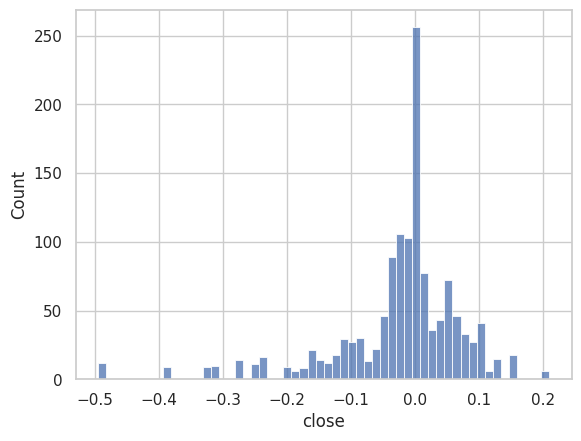

In [8]:
sns.histplot( dfo[(dfo['Horizon']==0)]['close'])

In [41]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(df.iloc[0])

date            #2023-09-12 15:58:58#
Horizon                             0
spot                          0.71611
dtm                                 3
level                         0.00011
slope                          0.0003
curve                        -0.00025
dtm1                                8
level1                        0.00034
slope1                       -0.00005
curve1                        0.00003
dtm2                               13
level2                        0.00049
slope2                       -0.00006
curve2                       -0.00005
dtm3                               18
level3                        0.00033
slope3                       -0.00005
curve3                        0.00007
date_1                    45174.62116
date_2                    45175.66568
date_3                    45176.65256
date_4                    45177.66736
date_5                    45180.65479
date_6                    45181.66728
diff_1                             50
diff_2      

In [ ]:
    # setup_data()
    df=dfo[(dfo['date_1']>45174.62)&(dfo['date_1']<45174.63)&(dfo['date_5']>45180.65)&(dfo['date_6']>45181.66)&(dfo['diff_1']==50)&(dfo['Horizon']==0)&(dfo['dtm']==3)]
    X_= dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')
    model=my_model

    with torch.no_grad():
      model.eval()
      prediction = []
      for batch in zero.iter_batches(X_, batch_size):
      # batch=next(zero.iter_batches(X['test'], batch_size))
      # if True:
          prediction.append(apply_model(model,
                                        x_cat=batch[0] if len(cat_names)>0 else None,
                                        x_num=batch[1],x2=batch[2]))
      prediction = torch.cat(prediction)
      target = y[part]
      prediction2 = prediction[:,-y_cat:].argmax(1)
      mask = ~torch.isnan(target[:,:-1])
      score = (F.mse_loss(prediction[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
            ((target[:,-1]!=prediction2).sum()/len(prediction))

      score,target, prediction,prediction2
